In this notebook we will make an implementation of a quantum communication.

We will teleport a singel qubit, although

# Importing Libraries

In [1]:
!pip install qiskit==0.39.0
!pip install qiskit-ibmq-provider==0.19.2
!pip install qiskit-ignis
!pip install pylatexenc

In [2]:
from math import pi

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute

simulator = Aer.get_backend('qasm_simulator')

from qiskit import IBMQ
# We will insert the token of our account
IBMQ.save_account("5c243f2ce21147566296f15a6edd4413ecad461ab12027aa0ee65b5125285f448ec16af450d2f507bfd0f8e50e37fdd0ef042f1c9b34f2fded26dae40e14433b")

IBMQ.load_account() # Load account from disk
provider = IBMQ.get_provider(group='open')
device = provider.get_backend('ibm_sherbrooke')

from qiskit import execute
from qiskit.tools.monitor import job_monitor

from qiskit.visualization import plot_histogram

# For Error Mitigation
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

# For Noise Simulations
from qiskit.test.mock import FakeMelbourne
fake_device = FakeMelbourne()

from qiskit.providers.aer.noise import NoiseModel
import numpy as np

configrc.store_credentials:WARNING:2025-01-16 16:46:59,138: Credentials already present. Set overwrite=True to overwrite.
<ipython-input-2-751697d39314>:22: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
<ipython-input-2-751697d39314>:25: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeMelbourne


# Metric

This function analyzes the results of the quantum circuit:
<br><br>
As input we will insert the results from running the circuit and the indexes we want to evaluate in those results.
<br>
We will make the entanglement of two qubits and ew will see if they have been correctly entangled. To see this we are going to use 2 correction rounds (to verify if we have had an error) and then we will check in which of Bell states are our qubits. In teh case they are in phi+ state this will mean the entanglement has been done sucessfully, in other case it would mean that there is an error we haven't seen.
<br><br>
As output we will print different metrics showing how the communication has been done:

*   Success vs. failure counts.
*   Yield (success probability).
*   Distribution among Bell states (phi+, psi+, etc.).
*   Fidelity (closeness to the ideal Bell state).
*   This helps assess the quality of quantum communication.




<br><br><br>

The algorithm uses three qubits per chain (Alice and Bob) because:
<br>
One qubit participates in the quantum relay for entanglement swapping.
The other two qubits are used for distillation and error checks.<br>
In the final measurement:

Only the first qubit of Alice and the last qubit of Bob (from their respective chains) are measured for entanglement fidelity. This corresponds to the result register.

In [4]:
def metrics(counts, system = None, correctionQ = 0 ):
    success, fail = 0, 0
    phi_plus, psi_plus, phi_minus, psi_minus = 0, 0, 0, 0
    check = False

    for result in counts:


        if system == 'repeater':
          check = True
          for i in range(correctionQ):
            if result[i+3] != result[i+4+correctionQ]:
              check = False
              break
        if system == 'relay' or check:
            success += counts[result]

            if (result[1]=='0' and result[0]=='0'):
                phi_plus += counts[result]
            elif (result[1]=='0' and result[0]=='1'):
                psi_plus += counts[result]
            elif (result[1]=='1' and result[0]=='0'):
                phi_minus += counts[result]
            elif (result[1]=='1' and result[0]=='1'):
                psi_minus += counts[result]
        else:
            fail += counts[result]

    if system =='repeater':
      total = success + fail
      print('success:', success, ',', 'fail:', fail, ',', 'total:', total)
      yields = success/(total)
      print('yield:', yields, '\n')

    print('Among success, phi+:', phi_plus, ',', 'psi+:', psi_plus, ',', 'phi-:', phi_minus, ',', 'psi-:', psi_minus)
    fidelity = phi_plus/success
    print('fidelity', fidelity)

# Simple teleportation



In [5]:
def make_teleportation(message):
  # Step 1: Create the quantum circuit
  message_qreg = QuantumRegister(1, 'message')  # Message qubit
  alice_qreg = QuantumRegister(1, 'alice')     # Alice's qubits
  bob_qreg = QuantumRegister(1, 'bob')        # Bob's qubit
  cr = ClassicalRegister(3, 'register')         # Classical bits for communication


  # Create quantum circuit
  qc = QuantumCircuit(message_qreg, alice_qreg, bob_qreg, cr)

  # Step 2: Initialize the message state (|ψ>)
  message_state =message  # |ψ>
  qc.initialize(message_state, message_qreg)

  # Step 3: Create entanglement between Alice and Bob's qubits
  qc.h(alice_qreg[0])  # Hadamard on Alice's first qubit
  qc.cx(alice_qreg[0], bob_qreg[0])  # Entangle Alice's first qubit with Bob's qubit

  # Step 4: Perform a Bell-state measurement on message and Alice's qubits
  qc.cx(message_qreg[0], alice_qreg[0])  # CNOT
  qc.h(message_qreg[0])  # Hadamard
  qc.measure(message_qreg[0], cr[0])  # Measure message qubit
  qc.measure(alice_qreg[0], cr[1])  # Measure Alice's first qubit

  # Step 5: Bob applies corrections


  qc.z(bob_qreg[0]).c_if(cr[0], 1)  # Apply Z for '1' in message
  qc.x(bob_qreg[0]).c_if(cr[1], 1)  # Apply X for '1' in Alice



  # Step 6: Measure Bob's qubit
  qc.measure(bob_qreg[0], cr[2])  # Measure Bob's qubit

  return  qc


In [8]:
#In the plots we only want to show the result in Bob's qubit, so we are going to keep it in another dictionary.
def process_counts_to_bob(counts):
    counts2 = {}
    for key, value in counts.items():
        bob_bit = key[0]  # Get the first bit (corresponding to Bob)
        if bob_bit in counts2:
            counts2[bob_bit] += value
        else:
            counts2[bob_bit] = value
    return counts2

## Running on not noisy device

We will run our circuit in a real device to show how Alice's and Bob's qubits have got entangled.

In [9]:
from qiskit import IBMQ
from qiskit import execute
from qiskit.tools.monitor import job_monitor

IBMQ.load_account() # Load account from disk
provider = IBMQ.get_provider(group='open')
backend = provider.get_backend('ibm_sherbrooke')
shots = 8192


ibmqfactory.load_account:WARNING:2025-01-16 17:00:56,744: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run
This is the state of Alice and Bob's qubits after measurement {'1': 4201, '0': 3991} 



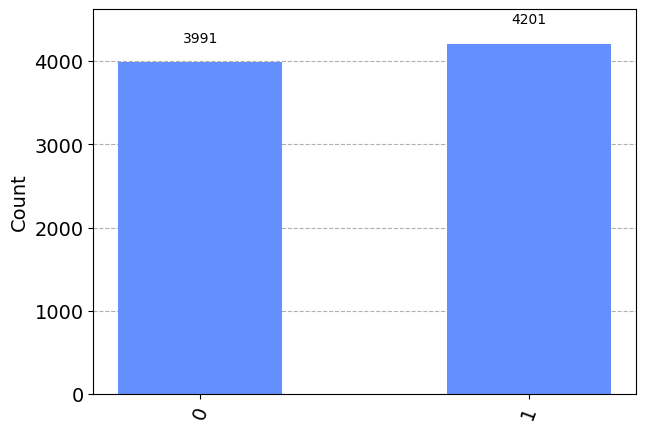

In [10]:
# Let see the teleportation with same probability for |0> and |1> states

job = execute(make_teleportation([1/np.sqrt(2), 1/np.sqrt(2)]), backend=simulator, shots=shots)

job_monitor(job)
device_result = job.result()
device_counts = device_result.get_counts()
device_counts = process_counts_to_bob(device_counts)

print("This is the state of Alice and Bob's qubits after measurement", device_counts,"\n")

plot_histogram(device_counts)

Job Status: job has successfully run
This is the state of Alice and Bob's qubits after measurement {'1': 8192} 



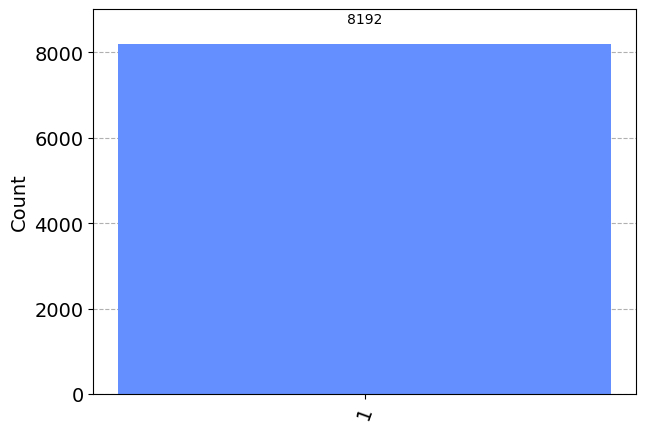

In [11]:
# Let see the teleportation with the next state:  0|0> + 1|1>

job = execute(make_teleportation([0,1]), backend=simulator, shots=shots)

job_monitor(job)
device_result = job.result()
device_counts = device_result.get_counts()
device_counts = process_counts_to_bob(device_counts)

print("This is the state of Alice and Bob's qubits after measurement", device_counts,"\n")

plot_histogram(device_counts)

Job Status: job has successfully run
This is the state of Alice and Bob's qubits after measurement {'1': 2711, '0': 5481} 



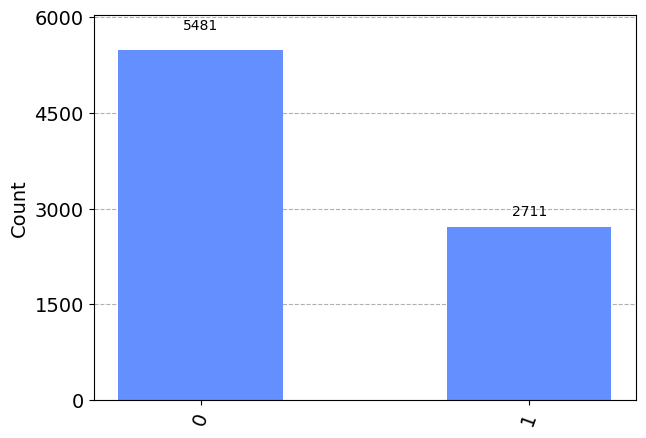

In [12]:
# Let see the teleportation with a state with a different amplitude.

job = execute(make_teleportation([np.sqrt(2)/np.sqrt(3), 1/np.sqrt(3)]), backend=simulator, shots=shots)

job_monitor(job)
device_result = job.result()
device_counts = device_result.get_counts()
device_counts = process_counts_to_bob(device_counts)

print("This is the state of Alice and Bob's qubits after measurement", device_counts,"\n")

plot_histogram(device_counts)

## Noisy simulation

In [14]:
noise_model = NoiseModel.from_backend(fake_device)
coupling_map = fake_device.configuration().coupling_map
basis_gates = noise_model.basis_gates

Job Status: job has successfully run

 
 This is the state of Alice and Bob's qubits after measurement {'1': 3898, '0': 4294} 



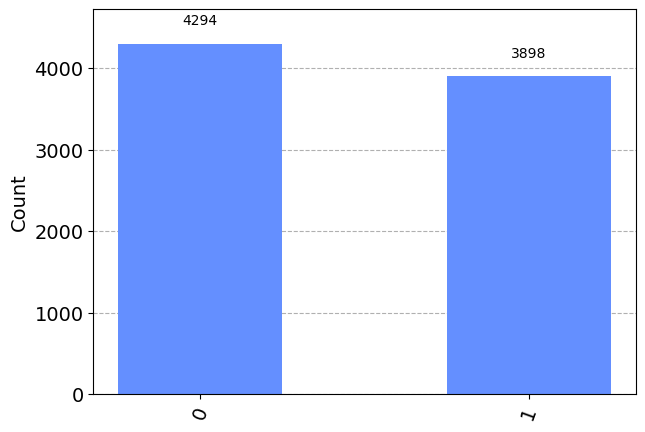

In [17]:
# Let see the teleportation with same probability for |0> and |1> states

noise_job = execute(make_teleportation([1/np.sqrt(2), 1/np.sqrt(2)]), simulator, shots=shots,
                       noise_model=noise_model,
                       #coupling_map=coupling_map,
                       basis_gates=basis_gates)

job_monitor(noise_job)
noise_result = noise_job.result()
noise_counts = noise_result.get_counts()

noise_counts = process_counts_to_bob(noise_counts)

print("\n \n This is the state of Alice and Bob's qubits after measurement", noise_counts,"\n")

plot_histogram(noise_counts)

Job Status: job has successfully run

 
 This is the state of Alice and Bob's qubits after measurement {'0': 5450, '1': 2742} 



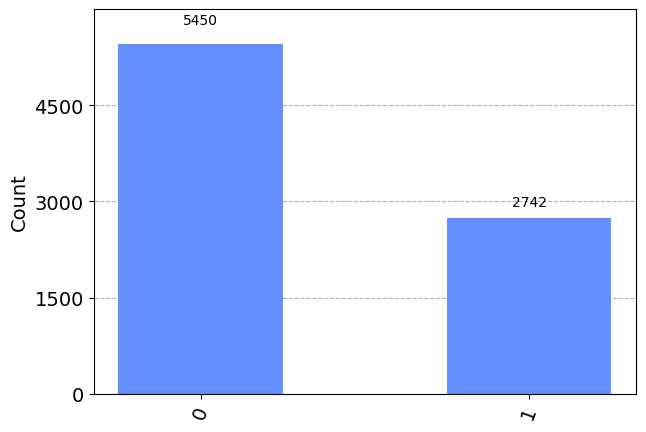

In [19]:
# Let see the teleportation with a state with a different amplitude.

noise_job = execute(make_teleportation([np.sqrt(2)/np.sqrt(3), 1/np.sqrt(3)]), simulator, shots=shots,
                       noise_model=noise_model,
                       #coupling_map=coupling_map,
                       basis_gates=basis_gates)

job_monitor(noise_job)
noise_result = noise_job.result()
noise_counts = noise_result.get_counts()

noise_counts = process_counts_to_bob(noise_counts)

print("\n \n This is the state of Alice and Bob's qubits after measurement", noise_counts,"\n")

plot_histogram(noise_counts)

Job Status: job has successfully run

 
 This is the state of Alice and Bob's qubits after measurement {'0': 947, '1': 7245} 



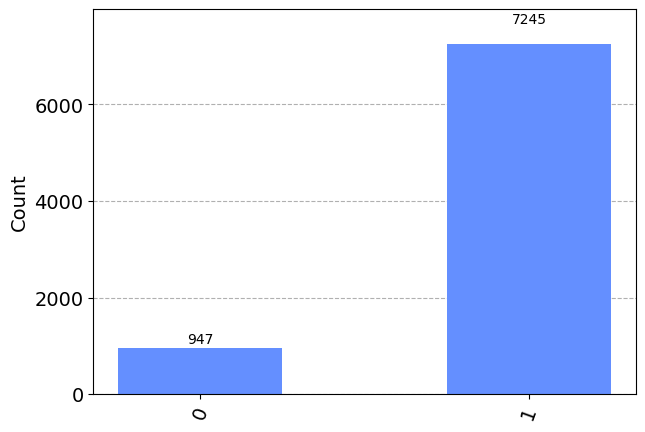

In [18]:
# Let see the teleportation with the next state:  0|0> + 1|1>

noise_job = execute(make_teleportation([0,1]), simulator, shots=shots,
                       noise_model=noise_model,
                       #coupling_map=coupling_map,
                       basis_gates=basis_gates)

job_monitor(noise_job)
noise_result = noise_job.result()
noise_counts = noise_result.get_counts()

noise_counts = process_counts_to_bob(noise_counts)

print("\n \n This is the state of Alice and Bob's qubits after measurement", noise_counts,"\n")

plot_histogram(noise_counts)

As we have done 8192 trials and we have done it well in 7245 the fidelity of this teleportation has been of 0.884.

# Building a quantum relay
 In this section we are going to implement a quantum relay. That means, we are going to entangle Bob's and Alice's qubits througha long distance but we are not going to look for security checks.

## Create sub-circuit for Entanglement-Swapping

We are creating the reusable instruction ent_swap. Thanks to it we will be able to create a Bell state between two distant qubits. The technique we are going to use is called entanglement swapping.

In [4]:
sub_q = QuantumRegister(3)
sub_circ = QuantumCircuit(sub_q, name='en\nsw')

sub_circ.cx(sub_q[0], sub_q[1])
sub_circ.h(sub_q[0])
sub_circ.cx(sub_q[1], sub_q[2])
sub_circ.cz(sub_q[0], sub_q[2])

ent_swap = sub_circ.to_instruction()

In [5]:
def quantumRelay():

  # preparing registers
  alice = QuantumRegister(2, 'alice')
  bob = QuantumRegister(2, 'bob')
  #MAry will act as a repeater, holding relays and quantum memories.
  mary = QuantumRegister(1, 'mary')
  result = ClassicalRegister(2, 'result')

  # constructing circuit
  sys = QuantumCircuit(alice, mary, bob, result)

  # Qubits in Alice's and Bob's registers are entangled with Hadamard (H) and CNOT gates. (this is done by pairs)
  sys.h(alice[0])
  sys.cx(alice[0], alice[1])

  sys.h(bob[0])
  sys.cx(bob[0], bob[1])

  sys.barrier()

  # transferring qubits to quantum relay (this is going to act as MAry)
  # One qubit from each of Alice's Bell pairs is swapped to the relay register using SWAP gates.
  # We are passing each of the entangled qubits to the relay.
  sys.swap(alice[1], mary[0])

  sys.barrier()

  # entanglement swapping extends entanglement over the quantum relay, we are entangling the information inside relay with Bob's qubits.
  #This creates long-distance entanglement between Alice and Bob.
  sys.append(ent_swap, [mary[0], bob[0], bob[1]])

  sys.barrier()

  # Deutsch's Correction corrects for phase errors introduced during the process.
  # This correction applies rotation gates (RX(pi/2)) to Alice's and Bob's qubits. The purpose is to:
  # Compensate for phase errors introduced during the communication process and align the qubits into a standard basis
  sys.rx(pi/2, alice[0])
  sys.rx(-pi/2, bob[1])


  #checking final fidelity through bell-measurement
  # we will measure the final Bell state for fidelity analysis.
  sys.cx(alice[0], bob[1])
  sys.h(alice[0])

  sys.measure([alice[0], bob[1]], [result[0], result[1]])

  path = '.'
  style = {'cregbundle': True, 'dpi': 1600, 'margin':[0.66,0,0,0], 'fontsize':13, 'subfontsize':10}
  sys.draw(output='mpl', style=style, plot_barriers=True, initial_state=True, with_layout=True, scale=0.7, filename=path+'circ_repeater.png')

  return sys

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/qcstyle.py:342: UserWarning: style option/s (cregbundle) is/are not supported
  set_style(current_style, style)


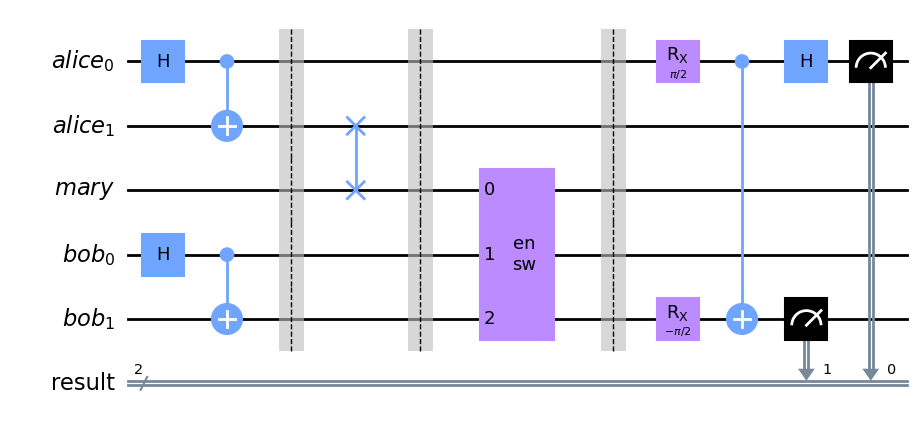

In [6]:
quantumRelay().draw(output='mpl')

## Running on not noisy device

We will run our circuit in a real device to show how Alice's and Bob's qubits have got entangled.

In [8]:
shots = 8192
job = execute(quantumRelay(), backend=simulator, shots=shots)

print(job.job_id())
job_monitor(job)

6ef7c5dd-b560-4587-8af9-2ad72394e50a
Job Status: job has successfully run


In [9]:
device_result = job.result()
device_counts = device_result.get_counts()

print("This is the state of Alice and Bob's qubits after measurement", device_counts,"\n")

metrics(device_counts,  system = 'relay')

This is the state of Alice and Bob's qubits after measurement {'00': 8192} 

Among success, phi+: 8192 , psi+: 0 , phi-: 0 , psi-: 0
fidelity 1.0


As we can see in the results, every time we have executed the circuit we have obtained a perfect entanglement. However, it has to be taken into account that this is an ideal case and that normally there is some noise.

## Noisy Simulation

In [11]:
noise_job = execute(quantumRelay(), simulator, shots=shots,
                       noise_model=noise_model,
                       #coupling_map=coupling_map,
                       basis_gates=basis_gates)

print(noise_job.job_id())
job_monitor(noise_job)
noise_result = noise_job.result()
noise_counts = noise_result.get_counts()

print(noise_counts)

metrics(noise_counts,  system = 'relay')
noise_result = noise_job.result()
noise_counts = noise_result.get_counts()

print("\n \n This is the state of Alice and Bob's qubits after measurement", noise_counts,"\n")

metrics(noise_counts,  system = 'relay')

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/qcstyle.py:342: UserWarning: style option/s (cregbundle) is/are not supported
  set_style(current_style, style)


89250135-6f5b-41ba-92c8-ec0709a9811d
Job Status: job has successfully run
{'01': 306, '11': 372, '10': 458, '00': 7056}
Among success, phi+: 7056 , psi+: 458 , phi-: 306 , psi-: 372
fidelity 0.861328125

 
 This is the state of Alice and Bob's qubits after measurement {'01': 306, '11': 372, '10': 458, '00': 7056} 

Among success, phi+: 7056 , psi+: 458 , phi-: 306 , psi-: 372
fidelity 0.861328125


After executing this quantum communication protocol in a real device we can see that we have a fidelity of 0.86. That means that the 86% of the entanglements are correctly done.

# Building Quantum-Repeater Circuit

Here we are going to buid a quantum communication system. Thanks to it Alice and Bob will communicate although they are at a very long distance between them.

The idea under the quantum repeater is that both Alice and Bob will send an  entangled qubit to a repeater. Here both qubits will be entangled. Thanks to it and to some memory which will help to avoid errors the qubit in ALice's hands and teh one in Bob's hands will get entangled. Then the process of sending the message should happen but this will be seen in a following section.

In [12]:
def quantum_repeater(correctionQubits):
  # no. of qubits
  n = correctionQubits +1

  # preparing registers
  alice = QuantumRegister(2*n, 'alice')
  bob = QuantumRegister(2*n, 'bob')
  # Mary will act as a relay.
  mary = QuantumRegister(n, 'mary')
  check_alice = ClassicalRegister(n-1, 'check\nalice')
  check_bob = ClassicalRegister(n-1, 'check\nbob')
  result = ClassicalRegister(2, 'result')

  # constructing circuit

  sys = QuantumCircuit(alice, mary, bob, check_alice, check_bob, result)

  # Qubits in Alice's and Bob's registers are entangled with Hadamard (H) and CNOT gates. (this is done by pairs)

  for i in range(0, 2*n, 2):
      sys.h(alice[i])
      sys.cx(alice[i], alice[i+1])

      sys.h(bob[i])
      sys.cx(bob[i], bob[i+1])

  sys.barrier()

  # transferring qubits to quantum relay
  # One qubit from each of Alice's Bell pairs is swapped to the relay register using SWAP gates.
  # We are passing each of the entangled qubits to the relay.

  for i in range (0, n):
      sys.swap(alice[2*i+1], mary[i])

  sys.barrier()

  # entanglement swapping extends entanglement over the quantum relay, we are entangling the information inside relay with Bob's qubits.

  #This creates long-distance entanglement between Alice and Bob.
  for i in range(0, n):
      sys.append(ent_swap, [mary[i], bob[2*i], bob[2*i+1]])

  sys.barrier()

  # Deutsch's Correction corrects for phase errors introduced during the process.
  # This correction applies rotation gates (RX(pi/2)) to Alice's and Bob's qubits. The purpose is to:
  # Compensate for phase errors introduced during the communication process and align the qubits into a standard basis
  for i in range(0, n):
      sys.rx(pi/2, alice[2*i])
      sys.rx(-pi/2, bob[2*i+1])

  sys.barrier()

  # bennett's protocol applies additional gates to improve the fidelity of communication.
  for i in range(2, 2*n, 2):
      sys.cx(alice[0], alice[i])
      sys.cx(bob[1], bob[i+1])

  sys.barrier()

  # distillation measures some qubits to purify the state and improve reliability.
  # sys.measure([alice[2], alice[4]], [check_alice[0], check_alice[1]])
  # sys.measure([bob[3], bob[5]], [check_bob[0], check_bob[1]])
  for i in range(1, n):
      sys.measure(alice[2*i], check_alice[i-1])
      sys.measure(bob[2*i+1], check_bob[i-1])

  sys.barrier()

  #checking final fidelity through bell-measurement
  # we will measure the final Bell state for fidelity analysis.
  sys.cx(alice[0], bob[1])
  sys.h(alice[0])

  sys.measure([alice[0], bob[1]], [result[0], result[1]])

  return sys



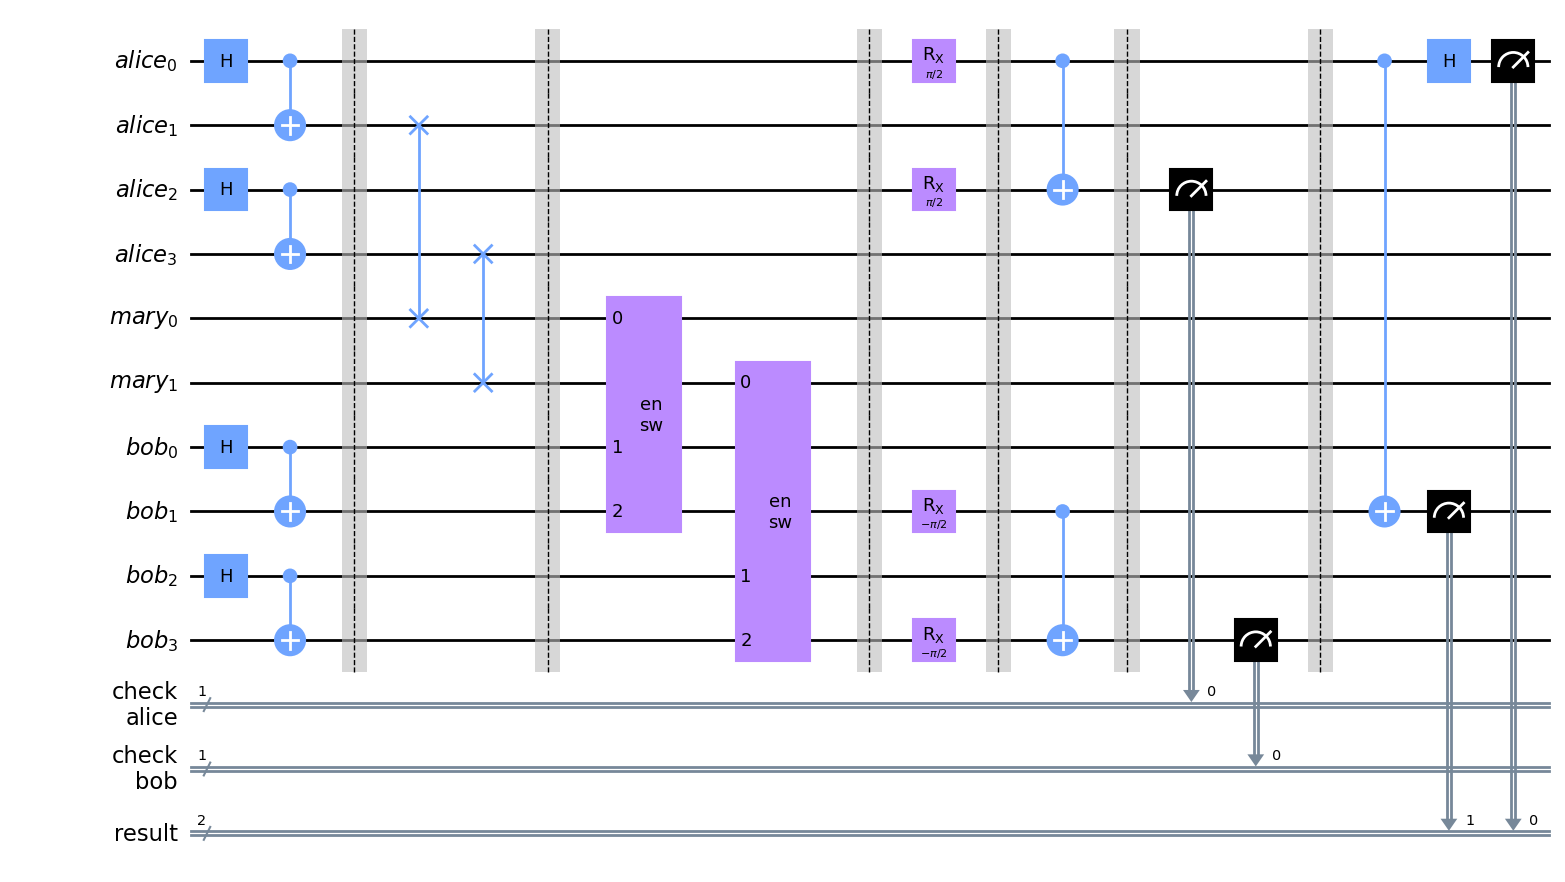

In [17]:
quantum_repeater(1).draw(output='mpl')

## Running on a not noisy device

We will run our circuit in a real device to show how Alice's and Bob's qubits have got entangled.

In [18]:
shots = 8192
job = execute(quantum_repeater(4), backend=simulator, shots=shots)

print(job.job_id())
job_monitor(job)

device_result = job.result()
device_counts = device_result.get_counts()

print(device_counts)
metrics(device_counts, system = 'repeater', correctionQ = 4)

04fd28ba-d07a-4945-a345-47f44817aa00
Job Status: job has successfully run
{'00 1001 1001': 561, '00 1110 1110': 549, '00 0110 0110': 511, '00 0000 0000': 469, '00 0010 0010': 581, '00 1100 1100': 491, '00 1111 1111': 482, '00 0100 0100': 499, '00 0111 0111': 487, '00 1010 1010': 483, '00 1000 1000': 485, '00 1101 1101': 537, '00 0001 0001': 487, '00 0101 0101': 537, '00 1011 1011': 540, '00 0011 0011': 493}
Among success, phi+: 8192 , psi+: 0 , phi-: 0 , psi-: 0
fidelity 1.0


As we can see in this results, all the times we have used our circuit there has been a success (we have not found errors). Morover, all the times we have tought there was a sucess there has been a real sucess (the fidelity is 1).

## Noisy Simulation
We are going to make 2 experiments: the first one with a single correction qubit and another trial with 4 correction qubits. Th e idea is thast as correction qubits increase in number the communication get more trustworthy.

In [17]:
noise_job = execute(quantum_repeater(1), simulator, shots=shots,
                       noise_model=noise_model,
                       #coupling_map=coupling_map,
                       basis_gates=basis_gates)

print(noise_job.job_id())
job_monitor(noise_job)
noise_result = noise_job.result()
noise_counts = noise_result.get_counts()

print(noise_counts)

metrics(noise_counts,  system = 'repeater', correctionQ = 1)
noise_result = noise_job.result()
noise_counts = noise_result.get_counts()

print("\n \n This is the state of Alice and Bob's qubits after measurement (there also appear teh correction qubits)", noise_counts,"\n")



1777b515-28a3-47a7-a8d2-fec6178c9d77
Job Status: job has successfully run
{'11 1 0': 37, '10 1 0': 39, '00 0 0': 3141, '00 1 0': 321, '10 1 1': 294, '00 1 1': 2821, '01 1 1': 158, '01 0 0': 180, '01 1 0': 141, '10 0 0': 315, '11 0 0': 23, '00 0 1': 432, '11 1 1': 18, '10 0 1': 68, '01 0 1': 155, '11 0 1': 49}
success: 6950 , fail: 1242 , total: 8192
yield: 0.848388671875 

Among success, phi+: 5962 , psi+: 609 , phi-: 338 , psi-: 41
fidelity 0.8578417266187051

 
 This is the state of Alice and Bob's qubits after measurement (there also appear teh correction qubits) {'11 1 0': 37, '10 1 0': 39, '00 0 0': 3141, '00 1 0': 321, '10 1 1': 294, '00 1 1': 2821, '01 1 1': 158, '01 0 0': 180, '01 1 0': 141, '10 0 0': 315, '11 0 0': 23, '00 0 1': 432, '11 1 1': 18, '10 0 1': 68, '01 0 1': 155, '11 0 1': 49} 



Those are the results obtained with a single sanity check: As we can see, although we have discarded the 84% of teh messages the results are worse than without correction qubits. We could think that it is because we have only used a single correction qubit. Lets try it with more.

In [18]:
noise_job = execute(quantum_repeater(2), simulator, shots=shots,
                       noise_model=noise_model,
                       #coupling_map=coupling_map,
                       basis_gates=basis_gates)

print(noise_job.job_id())
job_monitor(noise_job)
noise_result = noise_job.result()
noise_counts = noise_result.get_counts()

print(noise_counts)

metrics(noise_counts,  system = 'repeater', correctionQ = 2)
noise_result = noise_job.result()
noise_counts = noise_result.get_counts()

print("\n \n This is the state of Alice and Bob's qubits after measurement (there also appear teh correction qubits)", noise_counts,"\n")



9d6523e1-5a25-418d-9e79-e3c13887671d
Job Status: job has successfully run
{'11 01 11': 4, '10 11 01': 2, '11 10 10': 4, '11 11 10': 3, '01 11 11': 102, '01 10 11': 65, '01 00 00': 119, '10 11 00': 42, '00 11 11': 1163, '10 10 10': 20, '00 11 01': 189, '00 11 10': 113, '01 00 10': 59, '01 01 00': 57, '01 01 11': 54, '00 00 11': 39, '10 01 10': 41, '10 00 00': 15, '00 01 11': 230, '11 00 00': 4, '00 10 00': 214, '00 11 00': 23, '11 11 01': 4, '00 01 10': 23, '01 00 01': 64, '10 01 00': 13, '11 00 11': 33, '00 01 01': 1249, '11 01 00': 6, '10 11 10': 6, '11 11 00': 34, '10 01 11': 5, '00 01 00': 135, '11 01 10': 32, '10 00 11': 41, '10 10 11': 4, '11 10 11': 10, '00 10 11': 169, '01 10 00': 55, '00 00 01': 190, '01 10 10': 121, '01 11 01': 43, '00 00 00': 1428, '01 11 10': 55, '01 01 10': 13, '00 10 01': 39, '10 00 10': 15, '11 10 00': 9, '00 00 10': 260, '11 01 01': 5, '01 00 11': 20, '00 10 10': 1265, '11 10 01': 41, '11 00 01': 15, '10 01 01': 8, '01 11 00': 13, '11 00 10': 8, '01 01 0

When we use 2 correction qubits instead of 1 we discard the 31% of the communications but we have an accuracy of 90%. This shows how thanks to the use of corrections we can have very accurate communications. We are not going to make trials with more correction qubits because the execution time grows a lot when adding new correction qubits, but we can assume the system performs much better.


# Message transmission trough long distances using quantum communication

Now we are going to use the repeater created before to transmit a message form Alice to Bob. The idea is that after the sanity check we are going to discard those messages that seem to be contaminated.

In [120]:
def make_communication(message_info, real = True, correctionQubits = 2):

  # Number of entangled qubits (channels)
  n = correctionQubits +1

  # Preparing registers
  message = QuantumRegister(1, 'message')  # The message qubit
  alice = QuantumRegister(2 * n, 'alice')  # Alice's qubits
  bob = QuantumRegister(2 * n, 'bob')      # Bob's qubits
  mary = QuantumRegister(n, 'mary')  # Quantum relay
  check_alice = ClassicalRegister(n - 1, 'check\nalice')  # Alice's distillation checks
  check_bob = ClassicalRegister(n - 1, 'check\nbob')      # Bob's distillation checks
  result = ClassicalRegister(3, 'result')  # Final measurement results

  # Constructing the circuit
  sys = QuantumCircuit(message,alice, mary, bob, check_alice, check_bob, result)
  # Step 2: Initialize the message state (|ψ>)
  message_state =message_info  # |ψ>
  sys.initialize(message_state, message)

  # Qubits in Alice's and Bob's registers are entangled with Hadamard (H) and CNOT gates. (this is done by pairs)

  for i in range(0, 2*n, 2):
      sys.h(alice[i])
      sys.cx(alice[i], alice[i+1])

      sys.h(bob[i])
      sys.cx(bob[i], bob[i+1])

  sys.barrier()

  # transferring qubits to quantum relay
  # One qubit from each of Alice's Bell pairs is swapped to the relay register using SWAP gates.
  # We are passing each of the entangled qubits to the relay.

  for i in range (0, n):
      sys.swap(alice[2*i+1], mary[i])

  sys.barrier()

  # entanglement swapping extends entanglement over the quantum relay, we are entangling the information inside relay with Bob's qubits.

  #This creates long-distance entanglement between Alice and Bob.
  for i in range(0, n):
      sys.append(ent_swap, [mary[i], bob[2*i], bob[2*i+1]])

  sys.barrier()

  # Deutsch's Correction corrects for phase errors introduced during the process.
  # This correction applies rotation gates (RX(pi/2)) to Alice's and Bob's qubits. The purpose is to:
  # Compensate for phase errors introduced during the communication process and align the qubits into a standard basis
  for i in range(0, n):
      sys.rx(pi/2, alice[2*i])
      sys.rx(-pi/2, bob[2*i+1])

  sys.barrier()

  # bennett's protocol applies additional gates to improve the fidelity of communication.
  for i in range(2, 2*n, 2):
      sys.cx(alice[0], alice[i])
      sys.cx(bob[1], bob[i+1])

  sys.barrier()

  # distillation measures some qubits to purify the state and improve reliability.
  # sys.measure([alice[2], alice[4]], [check_alice[0], check_alice[1]])
  # sys.measure([bob[3], bob[5]], [check_bob[0], check_bob[1]])
  for i in range(1, n):
      sys.measure(alice[2*i], check_alice[i-1])
      sys.measure(bob[2*i+1], check_bob[i-1])

  sys.barrier()



  # Step 8: Teleport the message from Alice to Bob
  # Entangle the message with Alice's first qubit
  sys.cx(message[0], alice[0])
  sys.h(message[0])

  # # Measure Alice's qubits to perform the teleportation
  sys.measure(message[0], result[0])
  sys.measure(alice[0], result[1])

  # # Apply corrections on Bob's qubits based on Alice's measurements
  sys.z(bob[1]).c_if(result[0], 1)  # Apply X if Alice's message qubit is 1
  sys.x(bob[1]).c_if(result[1], 1)  # Apply Z if Alice's entangled qubit is 1

  sys.barrier()

  #Step 9: Measure Bob's qubit to retrieve the transmitted message
  sys.measure(bob[1], result[2])  # Measure Bob's first qubit



  if not real:
    return ideal_simulation(sys)
  else:
    return real_simulator(sys)


In [129]:
def ideal_simulation(sys):
  shots = 8192
  job = execute(sys, backend=simulator, shots=shots)
  device_result = job.result()
  device_counts = device_result.get_counts()
  return device_counts


def real_simulator(sys):
  shots = 8192
  noise_job = execute(sys, simulator, shots=shots,
                       noise_model=noise_model,
                       #coupling_map=coupling_map,
                       basis_gates=basis_gates)
  noise_result = noise_job.result()
  noise_counts = noise_result.get_counts()
  return noise_counts


In [113]:
#In the plots we only want to show the result in Bob's qubit, so we are going to keep it in another dictionary.
def process_counts_to_bob(counts):
    counts2 = {}
    counts2['0'] = 0
    counts2['1'] = 0
    counts2['failure'] = 0
    for results in counts:
        if results[4] == results[7] and results[5] == results[8]:
          if results[0]=='0':
            counts2['0'] += counts[results]
          else:
            counts2['1'] += counts[results]
        else:
          counts2['failure'] += counts[results]

    return counts2

## Not noisy simulation

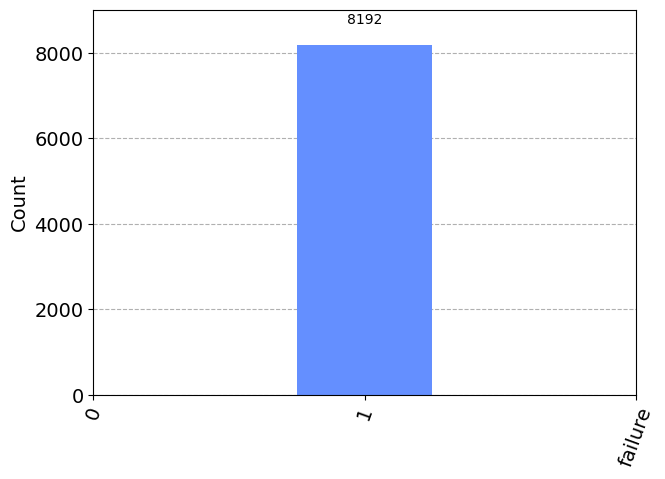

In [130]:
c = make_communication([0,1], real = False, correctionQubits = 4)
c = process_counts_to_bob(c)
plot_histogram(c)

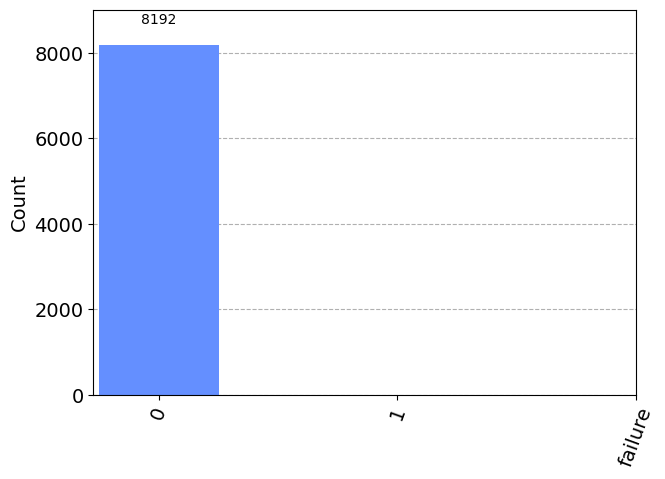

In [131]:
c = make_communication([1,0], real = False)
c = process_counts_to_bob(c)
plot_histogram(c)

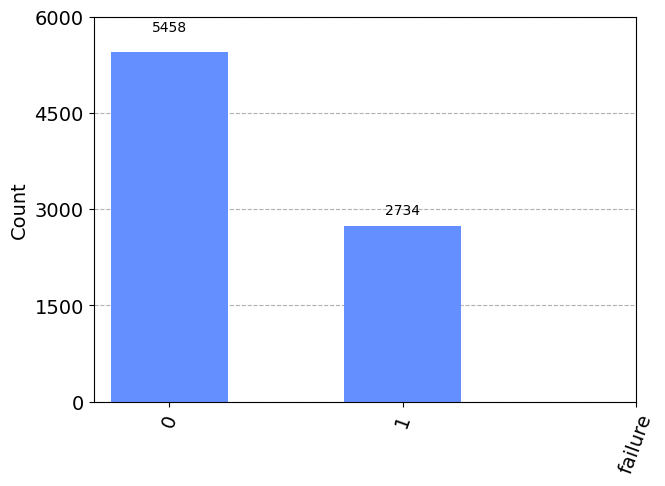

In [132]:
c = make_communication([np.sqrt(2)/np.sqrt(3), 1/np.sqrt(3)], real = False, correctionQubits = 4)
c = process_counts_to_bob(c)
plot_histogram(c)

## Noisy simulation

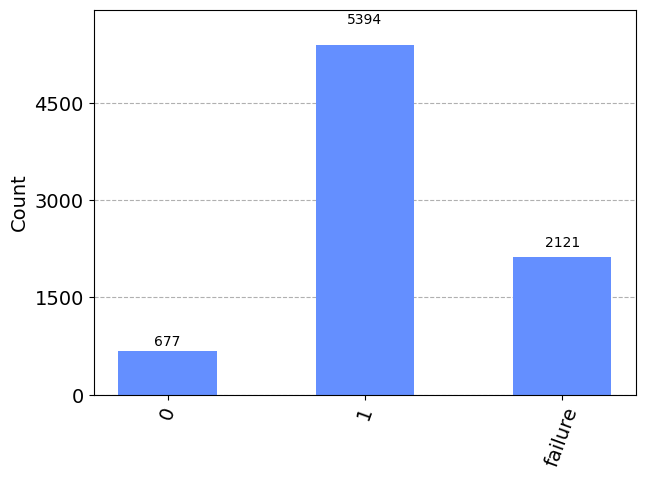

In [133]:
c = make_communication([0,1], real = True, correctionQubits = 4)
c = process_counts_to_bob(c)
plot_histogram(c)

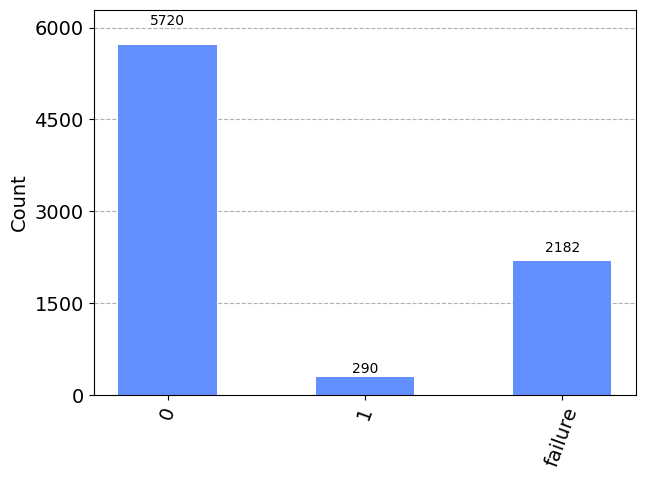

In [134]:
c = make_communication([1,0], real = True, correctionQubits = 4)
c = process_counts_to_bob(c)
plot_histogram(c)

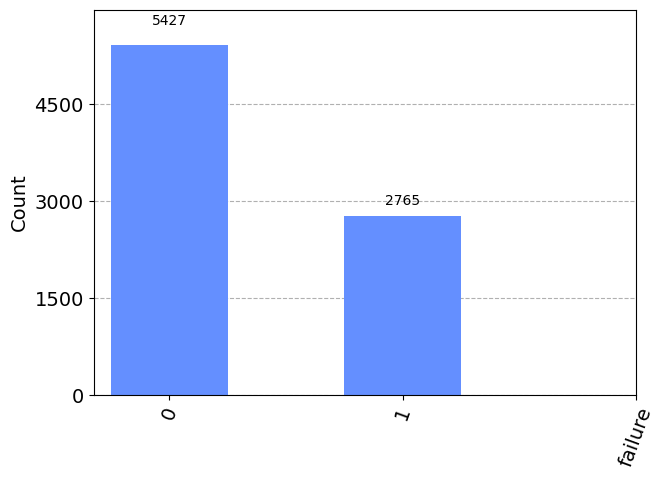

In [135]:
c = make_communication([np.sqrt(2)/np.sqrt(3), 1/np.sqrt(3)], real = True, correctionQubits = 4)
c = process_counts_to_bob(c)
plot_histogram(c)